In [102]:
# imports

# external modules
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import importlib
# framework modules
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import models.modeldefs
importlib.reload(models.modeldefs)
from models.modeldefs import model_dummy
# local modules
import prepare_training_set
importlib.reload(prepare_training_set)
from prepare_training_set import prepare_training_data_from_files

In [103]:
# load the training set

file = '../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet'

kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5,
    'veto_patterns': [np.zeros((2,2)), np.zeros((3,1)), np.zeros((1,3))]
})
(training_data, training_runs, training_lumis) = prepare_training_data_from_files([file], **kwargs)

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 69383 67139 23294]
  Passing number of entries: 16503 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Passing veto patterns: 8210 (45.45 %)
  Training lumisections: 8081 (44.73 %)
Shape of training data: (8081, 32, 32, 1)
Shape of training runs: (8081,)
Shape of training lumis: (8081,)


Text(0.02, 1.02, 'Shape mask')

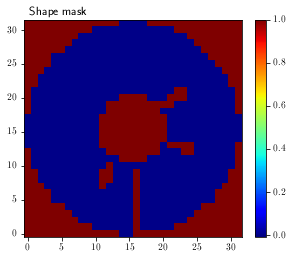

In [104]:
# make a mask where values are often zero

shape_mask = (np.sum(training_data[:,:,:,0]==0, axis=0)>len(training_data)/2.)

fig,ax = plt.subplots()
plot_histogram(shape_mask, fig=fig, ax=ax, caxrange=(-0.01,1))
ax.text(0.02, 1.02, 'Shape mask', transform=ax.transAxes, fontsize=12)

In [105]:
# make model and training settings
input_shape = training_data.shape[1:]
model = model_dummy(input_shape)
loss = 'mse'
optimizer = 'adam'
batch_size = 32
epochs = 30
validation_split = 0.1

# define callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 10, restore_best_weights = False)
tempname = 'temp_training_naive.keras'
if os.path.exists(tempname): os.system('rm {}'.format(tempname))
checkpoint = keras.callbacks.ModelCheckpoint(tempname, 
                    monitor='val_loss', mode='min', 
                    save_best_only=True, verbose=1)

# compile model
model.compile(
  loss=loss,
  optimizer=optimizer
)

# do training
history = model.fit(
    training_data, training_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=True,
    shuffle=True,
    validation_split=validation_split,
    callbacks=[early_stop, checkpoint]
)

# reload best model
model = keras.models.load_model(tempname)
os.system('rm {}'.format(tempname))

rm: cannot remove ‘temp_training_naive.keras’: No such file or directory


Epoch 1/30
228/228 [==============================] - ETA: 0s - loss: 0.0017
Epoch 1: val_loss improved from inf to 0.00190, saving model to temp_training_naive.keras
228/228 [==============================] - 16s 40ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 2/30
227/228 [============================>.] - ETA: 0s - loss: 2.3809e-04
Epoch 2: val_loss improved from 0.00190 to 0.00093, saving model to temp_training_naive.keras
228/228 [==============================] - 8s 34ms/step - loss: 2.3800e-04 - val_loss: 9.2577e-04
Epoch 3/30
227/228 [============================>.] - ETA: 0s - loss: 2.0488e-04
Epoch 3: val_loss improved from 0.00093 to 0.00076, saving model to temp_training_naive.keras
228/228 [==============================] - 8s 34ms/step - loss: 2.0480e-04 - val_loss: 7.5794e-04
Epoch 4/30
227/228 [============================>.] - ETA: 0s - loss: 1.4883e-04
Epoch 4: val_loss did not improve from 0.00076
228/228 [==============================] - 7s 33ms/step - loss: 1.48

0

In [106]:
# evaluate the model

training_predictions = model.predict(training_data)
training_predictions[training_predictions<0] = 0.
training_predictions[:,shape_mask] = 0.

253/253 [==============================] - 5s 16ms/step


Text(0.02, 1.02, 'Average response')

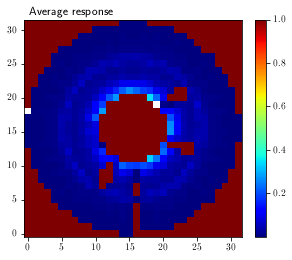

In [107]:
# calculate squared difference

training_errors = np.square(training_data - training_predictions)
avg_response = np.square(np.mean(training_data, axis=0)) # average occupancy
#avg_response = np.mean(training_errors, axis=0) # average error
avg_response[avg_response==0] = 1
training_errors_corrected = training_errors/avg_response

fig,ax = plt.subplots()
caxrange = None
#caxrange = (-0.001, 0.01)
plot_histogram(avg_response[:,:,0], fig=fig, ax=ax, caxrange=caxrange)
ax.text(0.02, 1.02, 'Average response', transform=ax.transAxes, fontsize=12)

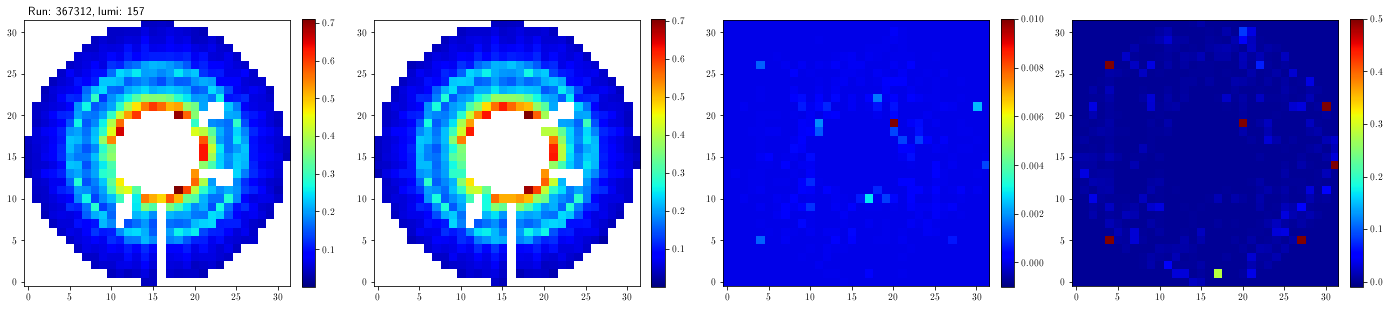

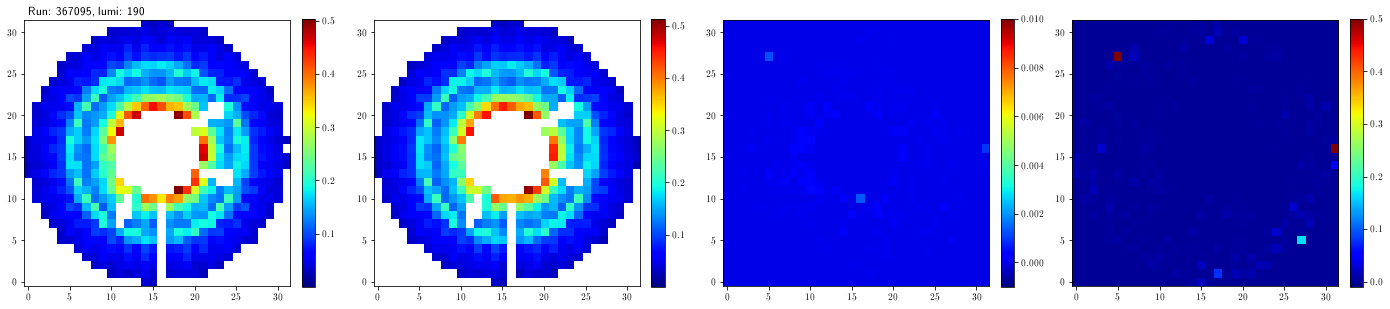

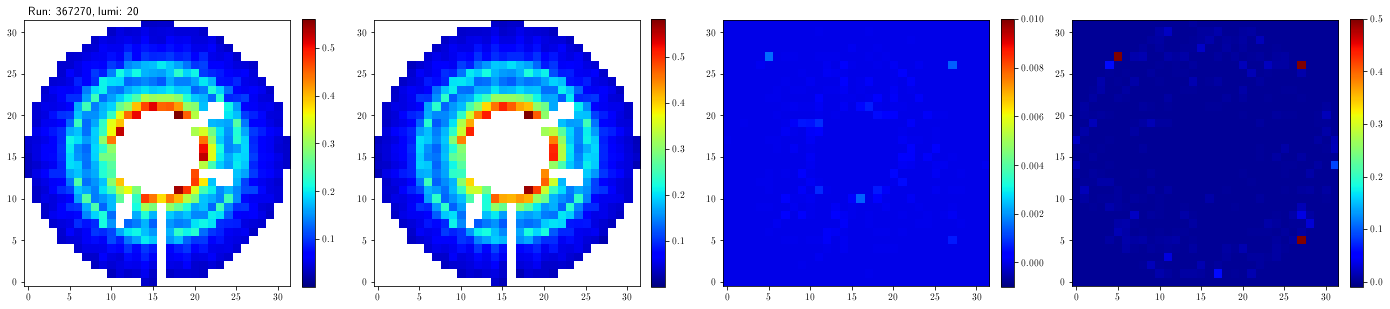

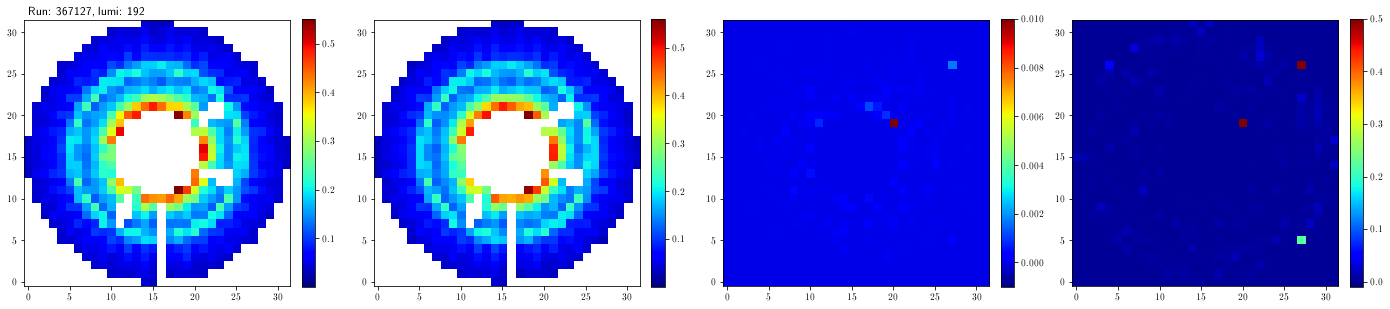

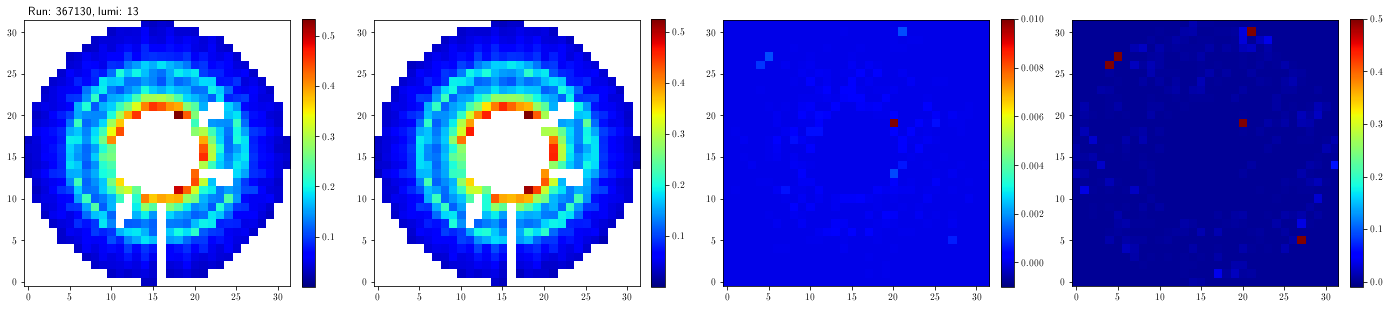

In [108]:
# make plots of instances in training set

nplots = 5
plotids = np.random.choice(len(training_data), size=nplots)

for i in plotids:
    fig,axs = plt.subplots(figsize=(24,6), ncols=4)
    plot_histogram(training_data[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(training_predictions[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(training_errors[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.001, 0.01))
    plot_histogram(training_errors_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01,0.5))
    axs[0].text(0.02, 1.02, 'Run: {}, lumi: {}'.format(training_runs[i], training_lumis[i]), transform=axs[0].transAxes, fontsize=12)

In [109]:
# load an evaluation set that is the complement of the training set

kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5,
    'required_patterns': [np.zeros((2,2)), np.zeros((3,1)), np.zeros((1,3))]
})
(eval_data, eval_runs, eval_lumis) = prepare_training_data_from_files([file], **kwargs)

eval_predictions = model.predict(eval_data)
eval_predictions[eval_predictions<0] = 0.
eval_predictions[:,shape_mask] = 0.

eval_errors = np.square(eval_data - eval_predictions)
eval_errors_corrected = eval_errors/avg_response

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 69383 67139 23294]
  Passing number of entries: 16503 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Passing required patterns: 9855 (54.55 %)
  Training lumisections: 8278 (45.82 %)
Shape of training data: (8278, 32, 32, 1)
Shape of training runs: (8278,)
Shape of training lumis: (8278,)
259/259 [==============================] - 4s 16ms/step


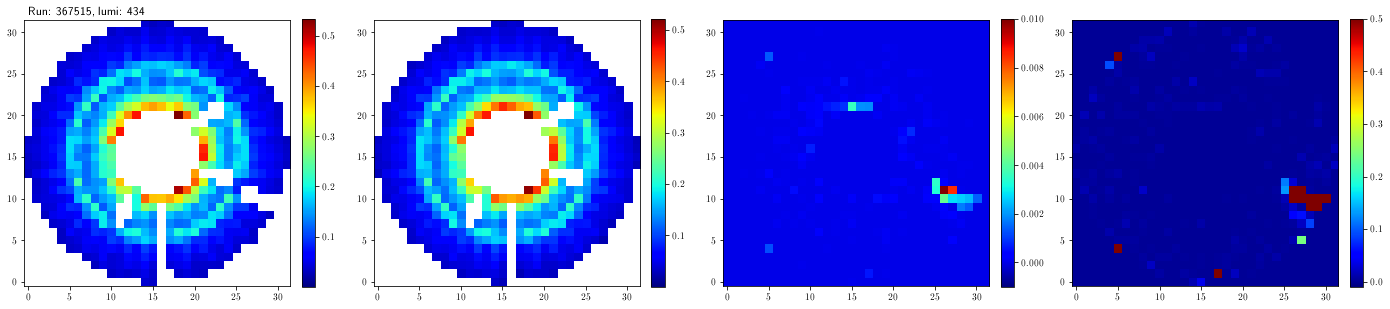

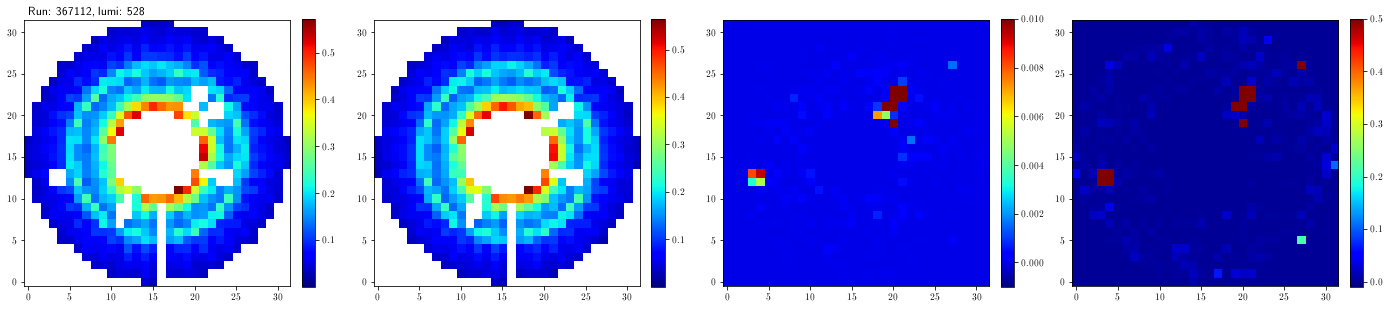

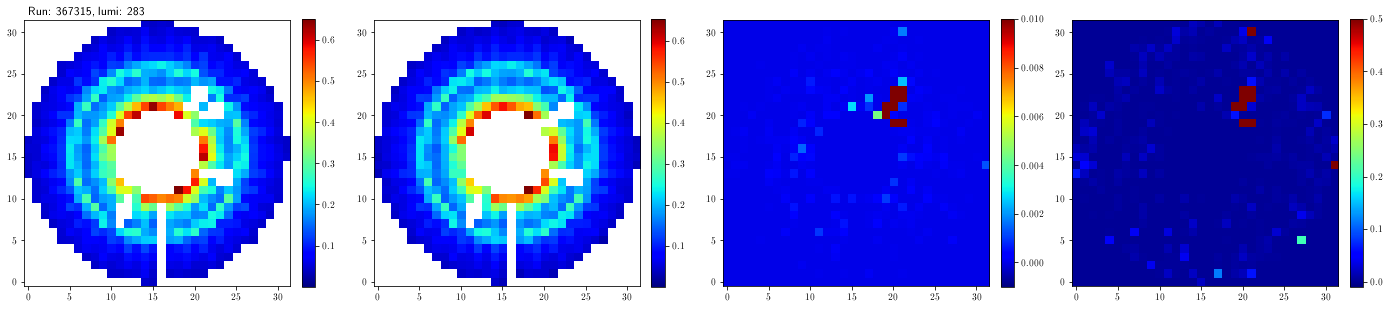

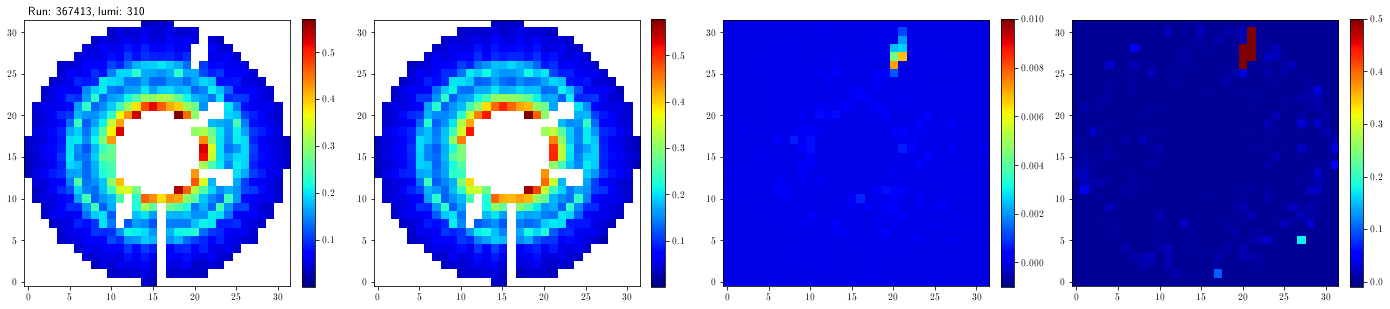

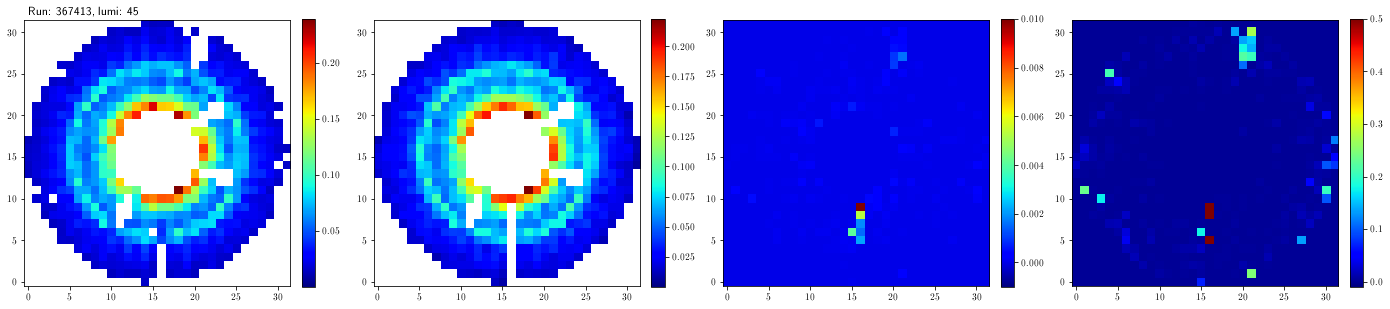

In [110]:
nplots = 5
plotids = np.random.choice(len(eval_data), size=nplots)

for i in plotids:
    fig,axs = plt.subplots(figsize=(24,6), ncols=4)
    plot_histogram(eval_data[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(eval_predictions[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(eval_errors[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.001, 0.01))
    plot_histogram(eval_errors_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, 0.5))
    axs[0].text(0.02, 1.02, 'Run: {}, lumi: {}'.format(eval_runs[i], eval_lumis[i]), transform=axs[0].transAxes, fontsize=12)

In [111]:
# store the model

dosave = False
if dosave:
    modelname = 'test_model_20231109_pxdisk+1_era2023Cv1.keras'
    model.save(modelname)